### Potential Field Path Planning

In [4]:
import numpy as np
import matplotlib.pyplot as plt

First read binary map generated from gazebo into a numpy matrix

In [5]:
def read_map(path='binary_map.txt'):
    m = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            m.append([int(x) for x in line.strip().split()])
    return np.flipud(np.array(m))

In [6]:
binary_map = read_map(path = "binary_map.txt")
binary_map.shape
border_width = 1  
constant_value = 1 
binary_map = np.pad(
    binary_map, 
    pad_width=border_width, 
    mode='constant', 
    constant_values=constant_value
)

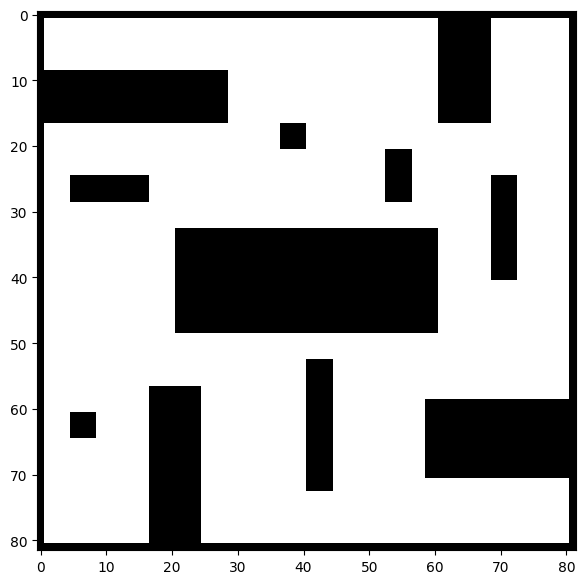

In [7]:
plt.figure(figsize=(10, 7))
plt.imshow(binary_map, cmap='gray_r')
plt.show()

Define starting and goal points

In [8]:
start = (1, 1)
goal = (50, 70)

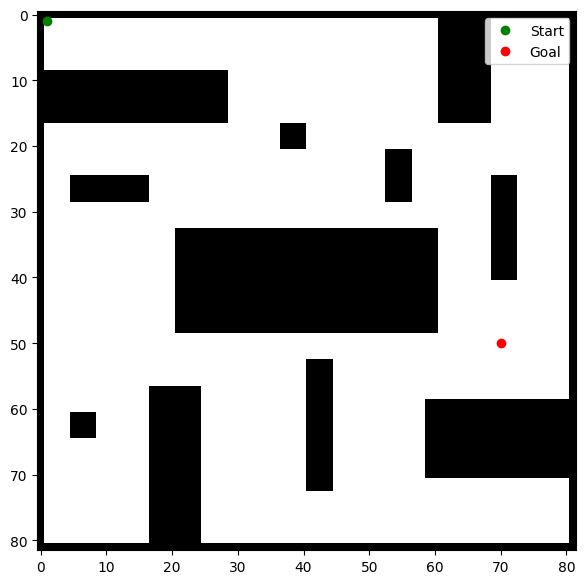

In [9]:
plt.figure(figsize=(10, 7))
plt.imshow(binary_map, cmap='gray_r')
plt.plot(start[1], start[0], 'go', label='Start')
plt.plot(goal[1], goal[0], 'ro', label='Goal')
plt.legend()
plt.show()

In [10]:
def att_potential(x, y, goal_x, goal_y, k_a = 1):
    att_force = 0.5 * k_a * ((x - goal_x)**2 + (y - goal_y)**2)

    return att_force

In [11]:
def rep_potential(x, y, obstacle_x, obstacle_y, d0, k_r = 100):
    rep_force = 0.0
    for ox, oy in zip(obstacle_x, obstacle_y):
        dx = x - ox
        dy = y - oy
        dist_sq = dx*dx + dy*dy
        if dist_sq <= d0**2:
            if dist_sq < 0.1:
                dist_sq = 0.1
            rep_force += 0.5 * k_r * (1.0 / dist_sq - 1.0 / d0**2)**2
    return rep_force

In [12]:
rows, cols = binary_map.shape 
U_att = np.zeros_like(binary_map, dtype=float)
U_rep = np.zeros_like(binary_map, dtype=float)

obstacle_y, obstacle_x = np.where(binary_map == 1)

for i in range(rows):
    for j in range(cols):
        U_att[i, j] = att_potential(j, i, goal[1], goal[0])
        U_rep[i, j] = rep_potential(j, i, obstacle_x, obstacle_y, d0=12)

U_total = U_att + U_rep

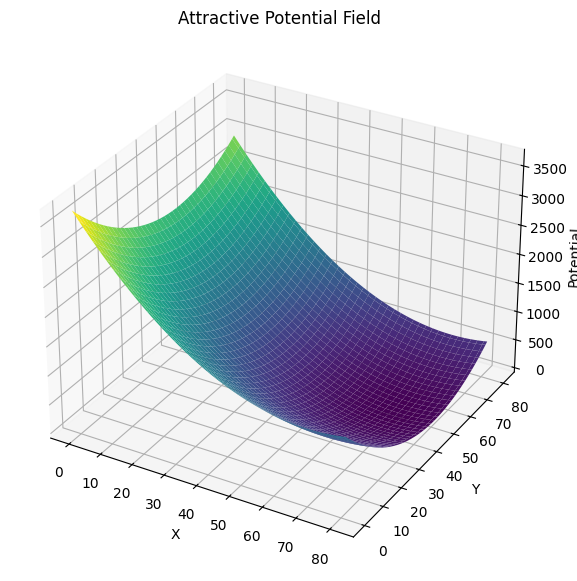

In [13]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(np.arange(U_total.shape[1]), np.arange(U_total.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, U_att, cmap='viridis', edgecolor='none')

ax.set_title("Attractive Potential Field")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')

plt.show()

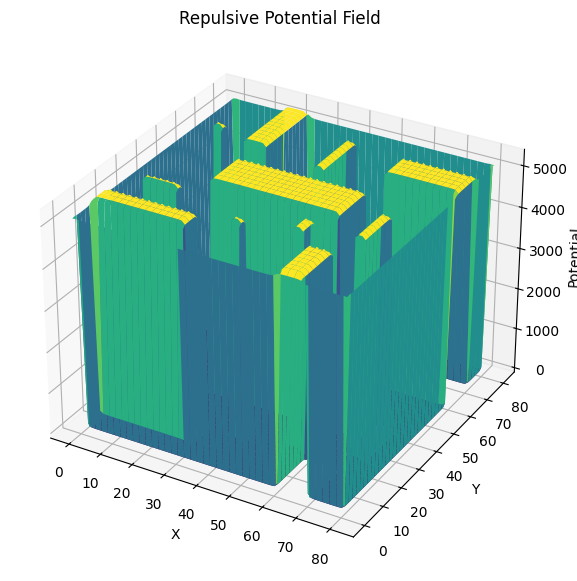

In [14]:
X, Y = np.meshgrid(np.arange(U_total.shape[1]), np.arange(U_total.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, U_rep, cmap='viridis', edgecolor='none')

ax.set_title("Repulsive Potential Field")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')

plt.show()

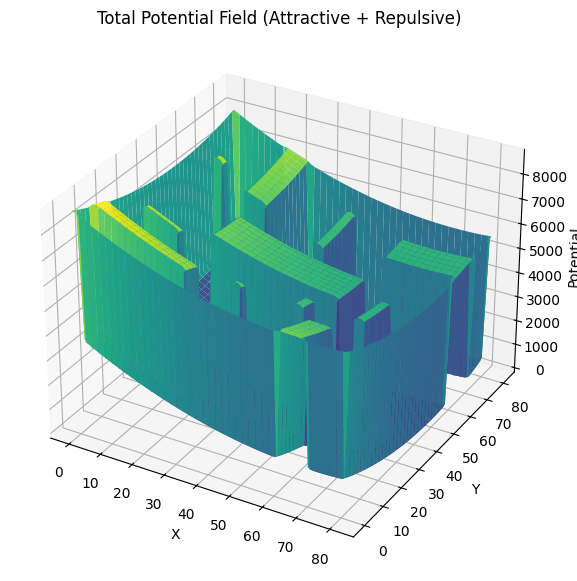

In [15]:
X, Y = np.meshgrid(np.arange(U_total.shape[1]), np.arange(U_total.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, U_total, cmap='viridis', edgecolor='none')

ax.set_title("Total Potential Field (Attractive + Repulsive)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')

plt.show()

In [16]:
def gradient_descent_path(U_total, start, goal, alpha=0.2, max_iter=1000, tol=1.0):
    """
    Compute a gradient descent path over a 2D potential field.
    
    Parameters:
    - U_total: 2D numpy array representing the potential field.
    - start: Tuple (y, x) of starting coordinates (row, column).
    - goal: Tuple (y, x) of goal coordinates (row, column).
    - alpha: Step size for gradient descent (default=0.2).
    - max_iter: Maximum iterations (default=1000).
    - tol: Termination tolerance for reaching goal (default=1.0).
    
    Returns:
    - path: List of (y, x) positions along the descent path.
    - reached_goal: Boolean indicating if goal was reached within tolerance.
    """
    rows, cols = U_total.shape
    Fx = np.zeros_like(U_total)
    Fy = np.zeros_like(U_total)
    
    Fx[:, 0] = U_total[:, 1] - U_total[:, 0] 
    Fx[:, -1] = U_total[:, -1] - U_total[:, -2]
    Fx[:, 1:-1] = (U_total[:, 2:] - U_total[:, :-2]) / 2.0 
    
    Fy[0, :] = U_total[1, :] - U_total[0, :]
    Fy[-1, :] = U_total[-1, :] - U_total[-2, :] 
    Fy[1:-1, :] = (U_total[2:, :] - U_total[:-2, :]) / 2.0 
    
    grad_mag = np.hypot(Fx, Fy)
    valid_mask = grad_mag > 0
    Fx_norm = np.divide(Fx, grad_mag, where=valid_mask, out=np.zeros_like(Fx))
    Fy_norm = np.divide(Fy, grad_mag, where=valid_mask, out=np.zeros_like(Fy))
    
    # Gradient descent from start to goal
    path = [start]
    current = np.array(start, dtype=float)
    reached_goal = False
    
    for _ in range(max_iter):
        y_idx = int(np.clip(current[0], 0, rows - 1))
        x_idx = int(np.clip(current[1], 0, cols - 1))
        
        step = alpha * np.array([-Fy_norm[y_idx, x_idx], -Fx_norm[y_idx, x_idx]])
        current = np.clip(current + step, 0, [rows - 1, cols - 1])
        path.append(tuple(current))
        
        if np.hypot(current[1] - goal[1], current[0] - goal[0]) < tol:
            reached_goal = True
            break
    
    return path, reached_goal

path, reached_goal = gradient_descent_path(U_total, start, goal)

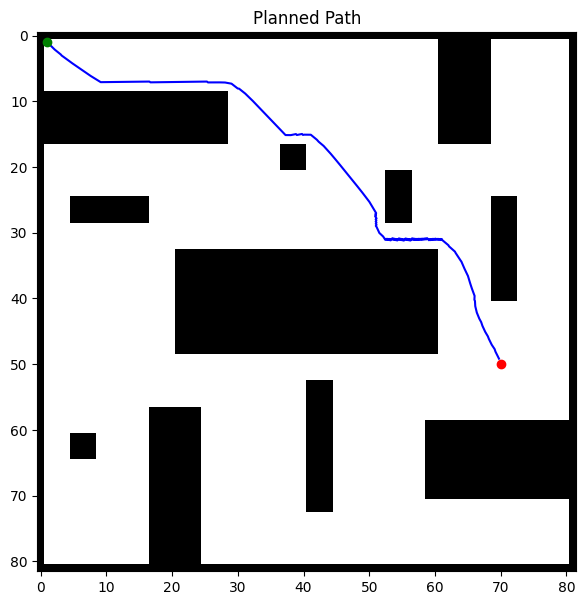

In [17]:
px, py = zip(*path)

plt.figure(figsize=(10, 7))
plt.imshow(binary_map, cmap='gray_r')
plt.plot(py, px, 'b-')
plt.plot(start[1], start[0], 'go')
plt.plot(goal[1], goal[0], 'ro')
plt.title("Planned Path")
plt.show()